In [1]:
import pandas as pd
import numpy as np

from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import warnings
warnings.filterwarnings("ignore")
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesse
 
import shap
from dataset import engine, RFM, Churn, Engagement, RFM_engage, RFM_churn
from models import CLFSwitcher, Transform, Pipe, parameters
from sklearn.model_selection import GridSearchCV

In [2]:
rfm = RFM(engine)

engage = Engagement(engine)

churn = Churn(engine)
# churn = churn.get_dataset()[['customer_id', 'churn']]

In [3]:
churn = RFM_churn(rfm, churn)

In [4]:
# engage = RFM_engage(rfm, engage)

In [5]:
data = churn
X = data.get_X()
y = data.get_y()
ct = Transform(data)
X, y = ct.get_Xy()
# ct.inverse_transform(pd.concat([X, y], axis=1))
# y

In [6]:
pipeline = Pipe(ct).get_pipeline()
def train(X, y, pipeline, parameters):
        grid_search = GridSearchCV(pipeline, parameters, cv=2, n_jobs=12, return_train_score=True, verbose=2)
        grid_search.fit(X, y)
        return grid_search, grid_search.best_estimator_[-1]
_, best_estimator = train(X, y, pipeline, parameters)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


In [7]:
best_estimator.explain(data, ct)


.values =
array([[ 5.11091780e-05,  8.82964684e-05, -9.57069322e-05,
         2.68533534e-04,  3.70609435e-05,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-2.12211285e-05,  3.01369089e-04, -1.49175159e-04,
         1.81259442e-04,  3.70609435e-05,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-1.36988840e-04,  1.42006813e-04,  1.77906119e-04,
        -8.35947994e-04,  3.70609435e-05,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-1.68649156e-04,  7.82212741e-05,  9.10381206e-06,
        -5.71699833e-04,  3.70609435e-05,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-1.01736014e-04,  3.83326980e-04, -1.39358021e-04,
         1.69999303e-04,  3.70609435e-05,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-2.12211285e-05,  3.01369089e-04, -1.49175159e-04,
         1.81259442e-04,  3.70609435e-05,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-2.12211285e-05,

In [8]:
shap_df = best_estimator.get_shap(X_col='yearly_income', y_col='churn', y_val='yes')
shap_df

{'gender': array(['Female', 'Male'], dtype=object), 'yearly_income': array([Decimal('920'), Decimal('8526'), Decimal('9766'), Decimal('9795'),
       Decimal('10782'), Decimal('10869'), Decimal('11566'),
       Decimal('12044'), Decimal('12796'), Decimal('13089'),
       Decimal('13937'), Decimal('16628'), Decimal('17078'),
       Decimal('18100'), Decimal('18935'), Decimal('19225'),
       Decimal('19682'), Decimal('21876'), Decimal('22557'),
       Decimal('22583'), Decimal('22650'), Decimal('22726'),
       Decimal('23103'), Decimal('23231'), Decimal('23371'),
       Decimal('23469'), Decimal('23821'), Decimal('23993'),
       Decimal('24155'), Decimal('24420'), Decimal('24545'),
       Decimal('24917'), Decimal('24960'), Decimal('25883'),
       Decimal('26510'), Decimal('26613'), Decimal('26676'),
       Decimal('27691'), Decimal('27763'), Decimal('27861'),
       Decimal('27952'), Decimal('28134'), Decimal('28147'),
       Decimal('28738'), Decimal('29517'), Decimal('30248'),
   

,shap,yearly_income__yes
0,-9.570693e-05,104049
1,-1.491752e-04,67444
2,1.779061e-04,36753
3,9.103812e-06,70862
4,-1.393580e-04,60292
...,...,...
95,4.468682e-07,51788
96,-2.714965e-04,31121
97,4.663850e-04,31739
98,2.542308e-05,63974


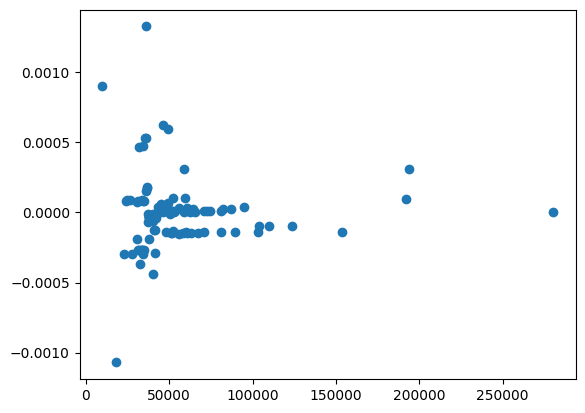

In [9]:
plt.scatter(shap_df.iloc[:, -1], shap_df.iloc[:,0])